In [1]:
import pandas as pd
import numpy as np
from PIL import Image
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras import layers, optimizers
import tensorflow as tf

from common import IM_SIZE, N_LABELS, LABELS

In [2]:
data = pd.read_csv('fer2013/fer2013.csv')
label_binarizer = LabelBinarizer().fit(data['emotion'])

In [3]:
def preprocess(data, usage='Training'):
    ''' Returns train or test dataset '''
    groups = data.groupby('Usage')
    df_subset = groups.get_group(usage)
    
    imread = lambda x: np.fromstring(x, np.uint8, sep=' ')
    images = np.array([imread(x).reshape(*IM_SIZE,1) for x in df_subset['pixels']])
    images = images / float(images.max())
    
    y_bin = label_binarizer.transform(df_subset['emotion'])
    return images, y_bin
    
data_train = preprocess(data, 'Training')
data_test = preprocess(data, 'PrivateTest')

In [4]:
model = tf.keras.Sequential([
    layers.Conv2D(64, kernel_size=5, padding='same', input_shape=(48, 48, 1), activation='relu'),
    layers.Conv2D(64, kernel_size=5, padding='same', input_shape=(48, 48, 1), activation='relu'),
    layers.MaxPooling2D(pool_size=(2,2), strides=(2,2)),
    layers.Conv2D(128, kernel_size=3, padding='same', input_shape=(*IM_SIZE, 1), activation='relu'),
    layers.Conv2D(128, kernel_size=3, padding='same', input_shape=(*IM_SIZE, 1), activation='relu'),
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(N_LABELS, activation='softmax')])

model.compile(optimizer=optimizers.Adam(3e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.


In [5]:
model.fit(data_train[0], data_train[1], epochs=10, batch_size=64, validation_data=data_test)

Train on 28709 samples, validate on 3589 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/10
28709/28709 [==============================] - 22s 766us/step - loss: 1.6648 - acc: 0.3442 - val_loss: 1.4804 - val_acc: 0.4308
Epoch 2/10
28709/28709 [==============================] - 20s 709us/step - loss: 1.4390 - acc: 0.4492 - val_loss: 1.3303 - val_acc: 0.4837
Epoch 3/10
28709/28709 [==============================] - 20s 699us/step - loss: 1.2934 - acc: 0.5091 - val_loss: 1.2360 - val_acc: 0.5297
Epoch 4/10
28709/28709 [==============================] - 21s 727us/step - loss: 1.1631 - acc: 0.5657 - val_loss: 1.1953 - val_acc: 0.5366
Epoch 5/10
28709/28709 [==============================] - 21s 722us/step - loss: 1.0142 - acc: 0.6221 - val_loss: 1.1718 - val_acc: 0.5603
Epoch 6/10
28709/28709 [==============================] - 20s 709us/step - loss: 0.8532 - acc: 0.6853 - val_loss: 1.1934 - val_acc: 0.5575
Epoch 7/10
28709/28709 [==============================] - 20s 695us/s

In [6]:
test_loss, test_acc = model.evaluate(*data_test)
print('Test accuracy:', test_acc)

3589/3589 [==============================] - 1s 251us/step - loss: 1.6605 - acc: 0.5748
Test accuracy: 0.57481194


In [7]:
imgs = np.array([np.fromstring(x, np.uint8, sep=' ') for x in data['pixels']])
y_hat = model.predict(data_test[0])

In [8]:
y_hats = [x.argmax() for x in y_hat]
pd.Series(y_hats).value_counts()

3    919
4    671
6    627
2    514
0    455
5    374
1     29
dtype: int64

Zgaduję że Angry w 9.373283e-07 %
Zgaduję że Disgust w 2.5910885e-10 %
Zgaduję że Fear w 0.0002794648 %
Zgaduję że Happy w 0.80732745 %
Zgaduję że Sad w 3.78491e-07 %
Zgaduję że Surprise w 0.19223306 %
Zgaduję że Neutral w 0.0001586477 %
Czyli zgaduję że Happy
Naprawdę jest Angry


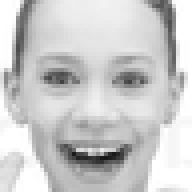

In [9]:
I = 10
for i in range(N_LABELS):
    print('Zgaduję że', LABELS[i], 'w', y_hat[I][i], '%')
print('Czyli zgaduję że', LABELS[y_hat[I].argmax()])
print('Naprawdę jest', LABELS[data['emotion'].tolist()[I]])
Image.fromarray((data_test[0][I]*255).reshape(IM_SIZE).astype(np.uint8), mode='L').resize((48*4, 48*4))


In [10]:
model.save('model.h5')